### Regression Models for Soarin' Wait Times

#### Overview
This notebook documents the regession modeling process to predict <i>Soarin'</i> wait times at a given time of day. This will incorporate other predictors explored in the notebook <tt>soarin_eda.ipynb</tt>. The following constraints will be in place in the modeling process:

- Predicted wait times will be rounded to the nearest integer that is divisible by 5. Posted wait times for this attraction are only shown in increments of 5 minutes, so all models here will adhere to this level of precision as well.


- Each model will be constructed in such a way that all predictions must be greater than or equal to 0. If an algorithm may be capable of returning negative values, a natural log transform will be applied to the target variable.


- Records in which the posted wait time is 0 minutes will be removed from training, validation, and testing. This observation has been shown to be exceedingly rare. This will also allow for easier implementation of log transforms without having to further perturb the data (ex. adding 1 to each value).


- Only records that were measured between 7am and 11pm will be considered. From exploratory analysis, measurement counts outside of this window are very rare and may be related to special events.


- Model selection will be done on the basis of mean absolute error, though we will still investigate other metrics such as R<sup>2</sup>. Mean absolute error will probably be more interpretable for a user, and thus may be more useful for selection.

#### Packages and Data Load

In [69]:
# Packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
import sqlite3
import plotly.express as px

In [2]:
# Pull Soarnin' data
# This query differs from the exploratory analysis in that:
# Wait times are dropped if they equal 0
# Only observations between 7am-11pm are considered
# Does not pull the yyyy-mm-dd date string as it is unnecessary
# Adds a column for a continuous measure of time (ex 8.5 is 8:30 am, 13.33 is 1:20pm)

with open('../src/soarin_query_model.sql', 'r') as sqlfile:
    soarin_query = sqlfile.read()

with sqlite3.connect('../data/project_data.db') as conn:
    soarin_df = pd.read_sql(soarin_query, con=conn)

In [3]:
# View the column names and indices for future reference
for idx, value in enumerate(soarin_df.columns):
    print(idx, value)

0 year_of_calendar
1 month_of_year
2 day_of_month
3 day_of_week
4 hour_of_day
5 minute_of_day
6 time_cont
7 tmax
8 days_tofrom_holiday
9 unemp_local_change
10 unemp_natl_change
11 cpi_natl_change
12 avg_wait_time_prev
13 wait_time


In [14]:
# Random seed
SEED = 42

#### Train/Dev/Test Splitting
Separate train, validation, and test designations will be created based on year:

- Training : 2015-2017

- Validation : 2018

- Test : 2019

The train and validation sets will be merged into a single DataFrame which we will concatenate. Using a PredefinedSplit, we will perform any hyperparameter tuning using the validation portion.


This train/validation/test split will adhere to a proposed method in which we construct a model using the prior three years' worth of data to predict the following year. Therefore, we will first train on 2015-2017 to predict 2018 as validation. After an estimator is selected, we will retrain on 2016-2018 and use 2019 as our estimation of model accuracy.

In [62]:
# Year cutoffs
TRAIN_YEARS = [2015, 2016, 2017]
VALIDATION_YEARS = [2018]
RETRAIN_YEARS = [2016, 2017, 2018]
TEST_YEARS = [2019]

In [5]:
def make_data_arrays(df, years):
    context = df[df.year_of_calendar.isin(years)].reset_index(drop=True)
    X = context.drop(['wait_time'], axis=1)
    y = context.wait_time.values
    return X,y

In [63]:
# Make datasets
X_train_valid, y_train_valid = make_data_arrays(soarin_df, TRAIN_YEARS+VALIDATION_YEARS)
X_retrain, y_retrain = make_data_arrays(soarin_df, RETRAIN_YEARS)
X_test, y_test = make_data_arrays(soarin_df, TEST_YEARS)

In [7]:
# Predefined splits (-1 if training, 0 if validation)
train_valid_folds = np.isin(X_train_valid.year_of_calendar, TRAIN_YEARS)
split_object = PredefinedSplit(test_fold = train_valid_folds*-1)

#### Simple Baseline Model
The baseline model will use a very simplistic rule in which a prediction for any given time will just use the value of <tt>avg_wait_time_prev</tt>, the average wait time over the same hour measured the previous week. A simple pipeline consisting of selecting this column and performing a mean imputation step is used so that a prediction can be made.

There are no hyperparameters to tune in this case, but here we examine performance on the created validation set for further comparisons. In this case, we find a mean absolute error of just over 16 minutes.

In [8]:
# Helper functions and classes
def to_nearest_five(y):
    # Round values to the nearest integer divisible by 5
    return np.round(y/5, 0)*5

def exp_to_nearest_five(y):
        return np.round(np.exp(y)/5, 0)*5

class BaselineModel(BaseEstimator, RegressorMixin):
    # Very simple estimator that just returns the values of a pre-existing array
    def __init__(self, dummy_param=1):
        self.fit_performed = False
        self.dummy_param = dummy_param
    
    def fit(self, X, y):
        self.fit_performed = True
    
    def predict(self, X):
        return X.reshape(-1,)

In [47]:
# Baseline model 

def build_baseline_model():   
    
    # Pipeline just returns the values of the avg_wait_time_prev column
    pipe = Pipeline([
        ('select_prev', ColumnTransformer([
            ('prev_wait', 'passthrough', ['avg_wait_time_prev'])
        ], remainder='drop')),

        ('imputer', SimpleImputer(strategy='mean')),

        ('baseline_model', TransformedTargetRegressor(regressor=BaselineModel(), inverse_func=to_nearest_five))
    ])
    
    # Not a 'true' grid search, just training and exploring validation error
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = {'baseline_model__regressor__dummy_param':[1]},
        cv = split_object,
        scoring = ['neg_mean_absolute_error', 'r2'],
        refit = 'neg_mean_absolute_error'
    )
    
    return grid

In [48]:
baseline_grid = build_baseline_model()

In [49]:
baseline_grid.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('select_prev',
                                        ColumnTransformer(transformers=[('prev_wait',
                                                                         'passthrough',
                                                                         ['avg_wait_time_prev'])])),
                                       ('imputer', SimpleImputer()),
                                       ('baseline_model',
                                        TransformedTargetRegressor(inverse_func=<function to_nearest_five at 0x7fc14ad40f70>,
                                                                   regressor=BaselineModel()))]),
             param_grid={'baseline_model__regressor__dummy_param': [1]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [50]:
# MAE
round(baseline_grid.best_score_*-1,4)

16.0593

In [51]:
# R-squared
round(baseline_grid.cv_results_['mean_test_r2'].max(),4)

-0.0041

#### Linear Regression with L1 Regularization

A penalized linear regression is attempted first. Since the number of features is relatively small, we can spend some time attempting to engineer different transforms or use binning methods to try to capture non-linear effects in the data. Imputation and min-max scaling will also be applied to features where needed.


The planned input features and related transforms will include:

- <b>month_of_year</b>: One hot encoded

- <b>day_of_week</b>: One hot encoded

- <b>days_tofrom_holiday</b>: One hot encoded - if null, will encode as the 'category' 6

- <b>tmax (real)</b>: Identity

- <b>unemp_local_change</b>: Identity

- <b>unemp_natl_change</b>: Identity

- <b>cpi_natl_change</b>: Identity

- <b>time_cont</b>: Binning

- <b>avg_wait_time_prev</b>: Natural log


The target variable of <tt>wait_time</tt> will also be log transformed to ensure the model cannot output negative values. A grid search yields a candidate model with MAE of just under 14 minutes with an R^2 of 0.4.

In [44]:
def build_linear_model(hyperparams):
    # Construct a linear regression with L1 regularization that follows a pipeline
    # of various transforms and encodings
    
    # One hot handling for month, day of week
    date_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('one_hot', OneHotEncoder(drop=None))
    ])

    # One hot handling for days to/from holiday
    holiday_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value=6)),
        ('one_hot', OneHotEncoder(drop=None))
    ])

    # Handling for identity features
    identity_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('minmax', MinMaxScaler())
    ])

    # Binning
    binning_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('binning', KBinsDiscretizer(strategy='uniform'))
    ])

    # Log transform
    logarithm_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('log_xform', FunctionTransformer(func=np.log)),
        ('minmax', MinMaxScaler())
    ])

    # Combine into column transforms
    column_preprocessor = ColumnTransformer([
        ('date_pipe', date_pipeline, ['month_of_year', 'day_of_week']),
        ('holiday_pipe', holiday_pipeline, ['days_tofrom_holiday']),
        ('identity_pipe', identity_pipeline, ['tmax', 'unemp_local_change', 'unemp_natl_change','cpi_natl_change']),
        ('binning_pipe', binning_pipeline, ['time_cont']),
        ('logarithim_pipe', logarithm_pipeline, ['avg_wait_time_prev'])
    ])

    # Regression with transformed target
    linear_model = TransformedTargetRegressor(
        regressor = Lasso(random_state=SEED),
        func = np.log,
        inverse_func = exp_to_nearest_five,
        check_inverse = False # The rounding portion means the inverse will not be the same
    )

    # Model pipeline
    pipe = Pipeline([
        ('column_preprocessing', column_preprocessor),
        ('regression', linear_model)
    ])
    
    # Grid Search
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = hyperparams,
        cv = split_object,
        scoring = ['neg_mean_absolute_error','r2'],
        refit = 'neg_mean_absolute_error'
    )
    
    return grid

In [45]:
# Hyperparameters
hyperparams = {
    'column_preprocessing__binning_pipe__binning__n_bins': [5, 10, 15, 20, 25, 30],
    'regression__regressor__alpha': [0.001, 0.01, 0.1, 1, 10]
}

linear_reg_grid = build_linear_model(hyperparams=hyperparams)

In [46]:
linear_reg_grid.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('column_preprocessing',
                                        ColumnTransformer(transformers=[('date_pipe',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['month_of_year',
                                                                          'day_of_week']),
                                                                        ('holiday_pipe',
                                                                      

In [18]:
# Best MAE
round(linear_reg_grid.best_score_*-1,4)

13.7616

In [19]:
# R-squared for params returning best MAE
best_param_iter = linear_reg_grid.cv_results_['mean_test_neg_mean_absolute_error'].argmax()
round(linear_reg_grid.cv_results_['mean_test_r2'][best_param_iter],4)

0.4088

In [20]:
# Params for model with best MAE
linear_reg_grid.best_params_

{'column_preprocessing__binning_pipe__binning__n_bins': 30,
 'regression__regressor__alpha': 0.001}

#### XGBoost Regression

In [21]:
# Pipeline similar to the regression, with adjustments to which variables undergo
# certain transforms, removing min-max scaling, binning

def build_xgboost_model(hyperparams):

    # One hot handling for month, day of week
    date_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('one_hot', OneHotEncoder(drop=None))
    ])

    # One hot handling for days to/from holiday
    holiday_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value=6)),
        ('one_hot', OneHotEncoder(drop=None))
    ])

    # Handling for identity features
    identity_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median'))
    ])

    # Combine into column transforms
    column_preprocessor = ColumnTransformer([
        ('date_pipe', date_pipeline, ['month_of_year', 'day_of_week']),
        ('holiday_pipe', holiday_pipeline, ['days_tofrom_holiday']),
        ('identity_pipe', identity_pipeline, ['day_of_month','tmax', 'unemp_local_change', 'unemp_natl_change',
                                              'cpi_natl_change','time_cont','avg_wait_time_prev'])
    ])

    # Regression with transformed target
    gb_model = TransformedTargetRegressor(
        regressor = XGBRegressor(random_state=SEED, n_jobs=-1),
        func = np.log,
        inverse_func = exp_to_nearest_five,
        check_inverse = False # The rounding portion means the inverse will not be the same
    )
    
    # Model pipeline
    pipe = Pipeline([
        ('column_preprocessing', column_preprocessor),
        ('regression', gb_model)
    ])
    
    # Grid Search
    gb_reg_grid = GridSearchCV(
        estimator = pipe,
        param_grid = hyperparams,
        cv = split_object,
        scoring = ['neg_mean_absolute_error','r2'],
        refit = 'neg_mean_absolute_error',
        verbose=True,
        return_train_score=True
    )
    
    return gb_reg_grid

In [27]:
# Hyperparameters
hyperparams = {
    'regression__regressor__n_estimators': [5,10,20,25],
    'regression__regressor__max_depth': [5,6,7,8],
    'regression__regressor__eta':[0.1,0.2,0.3,0.4]
}

gb_reg_grid = build_xgboost_model(hyperparams=hyperparams)

In [28]:
gb_reg_grid.fit(X_train_valid, y_train_valid)

Fitting 1 folds for each of 64 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  2.1min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('column_preprocessing',
                                        ColumnTransformer(transformers=[('date_pipe',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['month_of_year',
                                                                          'day_of_week']),
                                                                        ('holiday_pipe',
                                                                      

In [29]:
# Best MAE
round(gb_reg_grid.best_score_*-1,4)

12.461

In [30]:
# R-squared for params returning best MAE
best_param_iter = gb_reg_grid.cv_results_['mean_test_neg_mean_absolute_error'].argmax()
round(gb_reg_grid.cv_results_['mean_test_r2'][best_param_iter],4)

0.4513

In [31]:
gb_reg_grid.best_params_

{'regression__regressor__eta': 0.3,
 'regression__regressor__max_depth': 7,
 'regression__regressor__n_estimators': 10}

#### Model Comparison
We have shown validation performance already, but we aggregate our findings here for convenience. Overall, using a boosted tree regressor (XGBoost) resulted in the highest R^2 and lowest mean absolute error. This configuration will be used for the final model.

In [33]:
models = [baseline_grid, linear_reg_grid, gb_reg_grid]
r2s = [round(i.cv_results_['mean_test_r2'][i.cv_results_['mean_test_neg_mean_absolute_error'].argmax()], 4)
     for i in models]
maes = [round(i.best_score_*-1,4) for i in models]

results = pd.DataFrame({
    'model_type': ['Baseline', 'Lasso', 'XGBRegressor'],
    'r2_value': r2s,
    'mae': maes
})

results.sort_values('mae', ascending=True)

,model_type,r2_value,mae
2,XGBRegressor,0.4513,12.4610
1,Lasso,0.4088,13.7616
0,Baseline,-0.0041,16.0593


#### Final Model and Test Error
Using the hyperparameter settings for the boosted tree regression pipeline, we retrain on years 2016, 2017, and 2018. We then compute our error metrics once more on the 2019 holdout set for our estimation of accuracy in practice. We end with an R^2 value of about 0.39, with a mean absolute error of around 12 minutes.

In [66]:
final_model_pipeline = clone(gb_reg_grid.best_estimator_)

In [67]:
final_model_pipeline.fit(X_retrain, y_retrain)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('date_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['month_of_year',
                                                   'day_of_week']),
                                                 ('holiday_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=6,
                                                                                 strategy='constant')),
                                                                  ('one_ho

In [70]:
pred = final_model_pipeline.predict(X_test)

In [73]:
round(r2_score(y_true=y_test, y_pred=pred),4)

0.3922

In [74]:
round(mean_absolute_error(y_true=y_test, y_pred=pred),4)

11.8547

#### Visualization

We can visualize model predictions for various dates to see how these might appear graphically:

In [75]:
def plot_actual_vs_pred(estimator, y, m, d):
    context = soarin_df[
        (soarin_df.year_of_calendar==y) & 
        (soarin_df.month_of_year==m) &
        (soarin_df.day_of_month==d)]

    preds = estimator.predict(context.drop('wait_time',axis=1).sort_values('time_cont'))

    actuals = context.sort_values('time_cont').wait_time

    times = context.sort_values('time_cont').time_cont

    plot_df = pd.DataFrame({'pred':preds, 'actual':actuals, 'time':times}).reset_index(drop=True)
    plot_df = pd.melt(frame=plot_df, id_vars='time', value_vars=['pred','actual'], 
                    var_name='group',value_name='wait_time')

    date_title = 'Predicted vs. Actual {0}-{1}-{2}'.format(m, d, y)

    return px.line(data_frame=plot_df, x='time', y='wait_time', color='group', title=date_title)

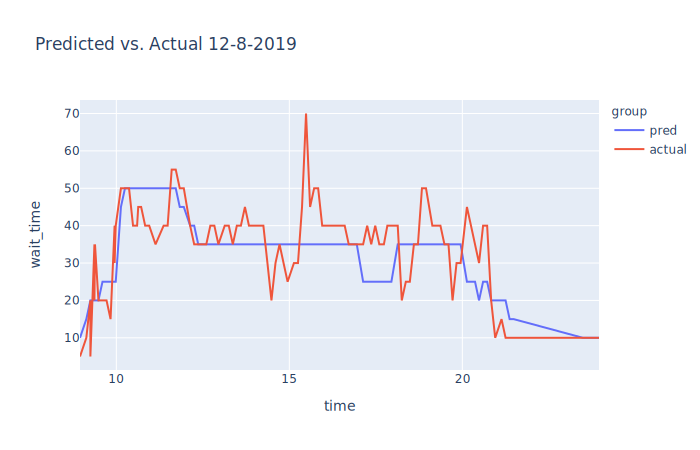

In [77]:
p = plot_actual_vs_pred(final_model_pipeline, y=2019, m=12, d=8)
p.show('svg')

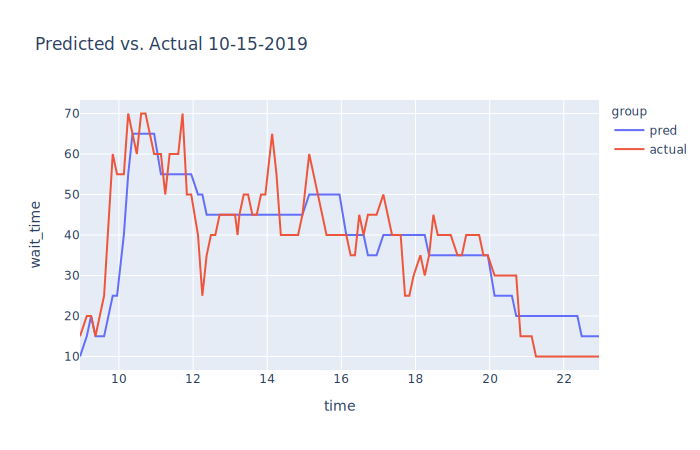

In [80]:
p = plot_actual_vs_pred(final_model_pipeline, y=2019, m=10, d=15)
p.show('svg')

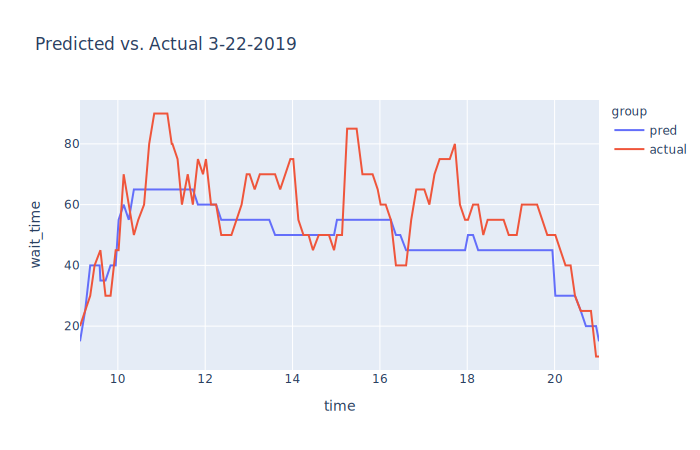

In [82]:
p = plot_actual_vs_pred(final_model_pipeline, y=2019, m=3, d=22)
p.show('svg')

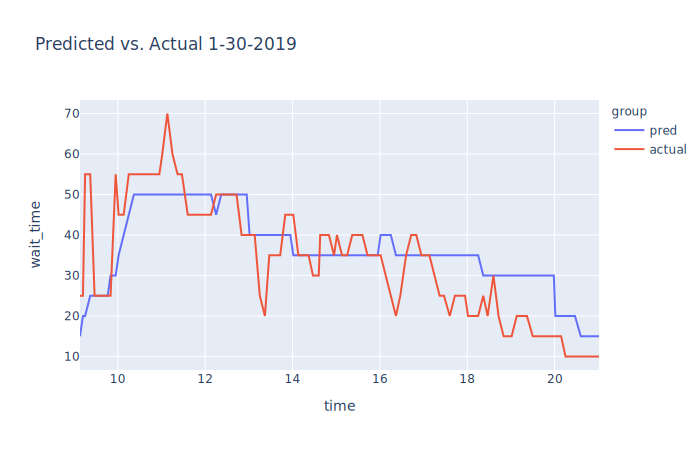

In [83]:
p = plot_actual_vs_pred(final_model_pipeline, y=2019, m=1, d=30)
p.show('svg')

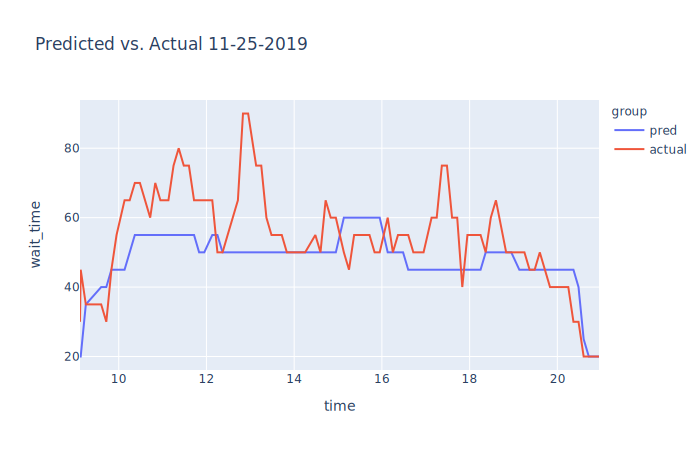

In [84]:
p = plot_actual_vs_pred(final_model_pipeline, y=2019, m=11, d=25)
p.show('svg')

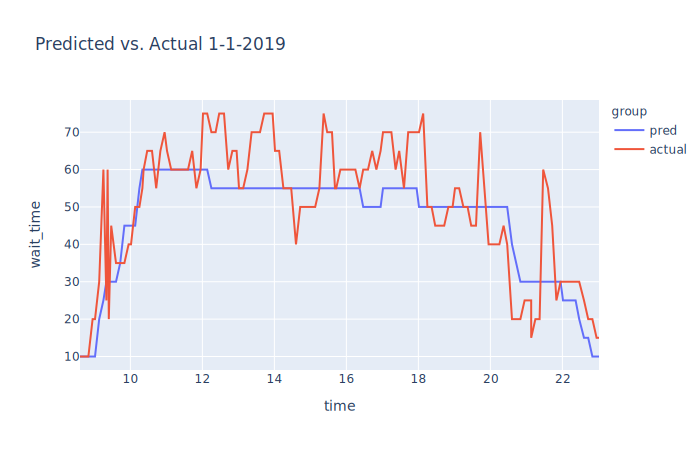

In [88]:
p = plot_actual_vs_pred(final_model_pipeline, y=2019, m=1, d=1)
p.show('svg')